# Logistic Regression on Smartphone Data

This data exploration uses the following dataset (modified for the course): [Human Activity Recognition Using Smartphones](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv)

The dataset was built from participants carrying smartphones embedded with inertial sensors while they were doing daily activities. These activities were classified into six categories: `['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']`.

The following is provided for each datapoint:
- Triaxial calculation form the accelerometer
- Triaxial angular velocity
- A 561-feature vector with time and frequency domain information
- Activity label

There are a total of 10299 datapoints. All columns (except the dcategory column) are floating point values scaled between -1.0 and 1.0. The categories are relatively evenly distributed and represented by a string variable.

In [46]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Exploring the data

First we check what the data looks like, there are a lot of compound measurements in the dataset, as indicated by the column names. These are all scaled ([-1.0, 1.0]) floating point values relating to the inertial measurements.

In [47]:
df = pd.read_csv("./data/Human_Activity_Recognition_Using_Smartphones_Data.csv")
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 44.2+ MB


Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [48]:
# Distribution of datatypes
df.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [49]:
# Distribution of values
df.iloc[:, :-1].min().value_counts(), df.iloc[:, :-1].max().value_counts()

(-1.0    561
 Name: count, dtype: int64,
 1.0    561
 Name: count, dtype: int64)

In [50]:
df.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

The category columns needs to be encoded before we can use it as a target variable in sklearn. For this we will use a labelencoder to interpret the categories as integers.

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])

## Exploring Correlations

Since the columns are combinations of other features, there are likely correlations. For model performance we need to find these.

In [52]:
feature_cols = df.columns[:-1]
corr_values = df[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
# tril -> triangular_lower
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack() # drops na values by default
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()
corr_values.head(5)

,feature1,feature2,correlation,abs_correlation
0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.128037,0.128037
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.230302,0.230302
2,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.004590,0.004590
3,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.016785,0.016785
4,tBodyAcc-mean()-X,tBodyAcc-std()-Z,-0.036071,0.036071


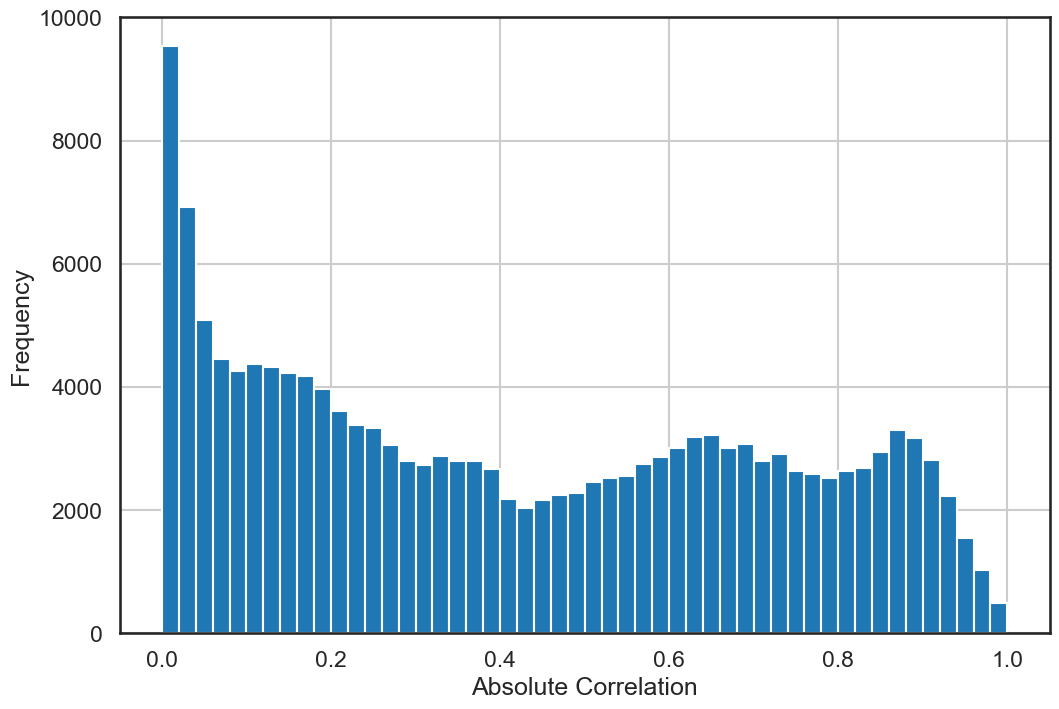

In [53]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

There are quite a bit of correlations, which is to be expected with 561 data columns. This leads to (561*561=314.721) / 2 (because we removed duplicates) = 157080 values. If we take a cutoff of >0.8 for correlations we want to consider (meaning 80% correlated), we get the following, leaving 22815 variables with high correlations.

In [54]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
156556,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
96366,tBodyAccMag-arCoeff()4,tGravityAccMag-arCoeff()4,1.000000,1.000000
109498,tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Preparing for training

To train the model we need to first split up the data. To keep the data categories consistent across splits, we will use `StratifiedShuffleSplit`. We only need a single split, but the stratification process ensures that the class distribution is as equal as possible between train and test sets.

In [55]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.3,
    random_state=42
)

# The stratified shuffle split splitter returns a generator that provides lists
# of indices to use for each split.
train_idx, test_idx = next(sss.split(df[feature_cols], df['Activity']))

X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'Activity']

X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, 'Activity']

## Fitting a model

With the data encoded and split up we can now fit a model to do some predictions. We'll do this for a basic model (without regularization). Then we can compare with regularized versions using cross validation.

In [56]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecate

## Comparing models

With the fitting done, we can compare the coefficients of the models.

In [57]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

# Build up our dataframe for plotting coeffizients
# Iterate over each model and label
# Then grab the coefficients for the model with shape (6, 561)
# For each output category, there is a separate 561 parameter linear model (One Vs All)
# We build a new MultiIndex object, labeling each iteration with the model name
# and 6 index values (one for each category). The codes parameter determines the mixing 
# of the two levels. In this case, since the list corresponding to 'lab' is all 0's,
# all 6 other values are mapped with 'lab'.
# Then we transpose the model coefficients to (561, 6) so the 6 category outputs
# are interpreted as columns. Do this for all models and concatenate to get the final
# multi-indexed dataset.
for lab, mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients: pd.DataFrame = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
250 -0.007395  0.327684 -0.165099  0.255974 -0.091374 -0.290584 -0.181361   
398 -0.012117  0.184953  0.200984  0.156287 -0.173779  0.117448 -0.027816   
111  0.011999  0.596054 -0.697590  0.034304 -0.245618 -0.413427  0.000000   
476 -0.000065  0.234434  0.212537  0.176167 -0.096810  0.344742 -0.009144   
12  -0.057144  0.466800  0.158404 -0.112618  0.892966 -0.742814  0.000000   
521 -0.025274  0.099147 -0.002325  0.001621  0.132813 -0.435023  0.000000   
7   -0.044016 -0.005861 -0.435470  0.246571 -0.433986 -0.090402 -0.000633   
469 -0.007690  0.202665  0.141815  0.013183 -0.585933  0.640041  0.000000   
341  0.018369  0.259945  0.154857 -0.092909  0.106691  0.288517 -0.009801   
171 -0.047500  0.007660  0.423715 -0.126342  0.926240 -0.960316 -0.203159   

                                                             l2            \
            1         2         3         4         5         0         1   
250  0.696544 -0.777511  0.000000 -0.899141  0.000000 -0.033615  1.126797   
398  0.000000  0.000000  0.243969  0.274227  0.000000 -0.040859  0.596709   
111  2.341988 -3.109022  0.000000 -0.582883 -1.712727  0.077131  4.663060   
476  0.271077  0.125231  0.000000  0.004911  0.278329 -0.022370  0.676471   
12   0.561888  0.000000  0.000000  2.852916 -1.746373 -0.100464  2.378343   
521  0.000000  0.000000  0.000000  0.000000 -0.472322 -0.062100  0.232808   
7    0.000000 -1.204569  0.000000 -0.072847  0.000000 -0.032279  0.824687   
469  0.000000  0.000162  0.000000 -0.527570  0.544140 -0.033531  0.502027   
341  0.000000  0.000000  0.000000  0.079694  0.357976  0.011837  0.630234   
171  0.000000  0.649658  0.000000  1.058584 -2.491755 -0.094489  0.022066   

                                             
            2         3         4         5  
250 -1.611903  0.852566 -0.419739 -1.010499  
398  0.590524  0.301371 -0.444745  0.612781  
111 -5.072997  0.080498 -0.459944 -1.920894  
476  0.516552  0.536168 -0.450998  1.645053  
12   0.127535 -0.694303  1.820578 -3.414124  
521 -0.195854  0.273444  0.288864 -1.484824  
7   -1.556715  0.771240 -0.611140 -0.701230  
469  0.129346  0.029335 -1.039688  2.073212  
341  0.153458 -0.289224  0.127775  1.182937  
171  1.756543 -0.440189  1.721920 -4.253058

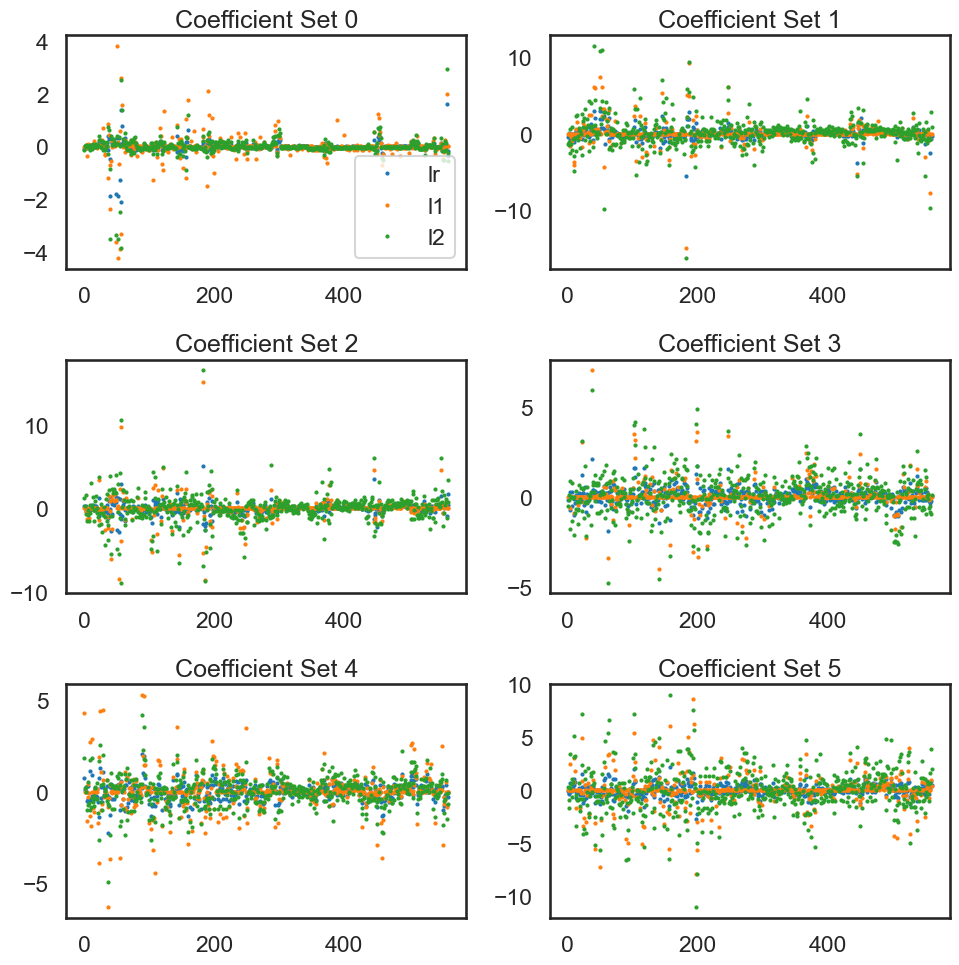

In [58]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    # Since we previously constructed the multiindexed data in a specific format
    # we can now easily extract the correct entries, by taking a view of the original data.
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Making Predictions

Now we'll use the model to make predictions on the test data. 

In [59]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head(), y_prob.head()

(   lr  l1  l2
 0   3   3   3
 1   5   5   5
 2   3   3   3
 3   1   1   1
 4   0   0   0,
          lr        l1        l2
 0  0.998939  0.998982  0.999998
 1  0.988165  0.999504  0.999477
 2  0.987592  0.995346  0.999697
 3  0.981381  0.999159  0.999865
 4  0.998277  0.999919  0.999997)

## Performance metrics

Finally, we can calculate performance metrics, like:
- Accuracy
- Precision
- Recall
- F-score
- Confusion Matrix

To see how each model performs.

In [60]:
from sklearn.metrics import precision_recall_fscore_support as prf_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [61]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = prf_score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,lr,l1,l2
precision,0.984144,0.983514,0.984477
recall,0.984142,0.983495,0.984466
fscore,0.984143,0.983492,0.984464
accuracy,0.984142,0.983495,0.984466
auc,0.990384,0.989949,0.990553


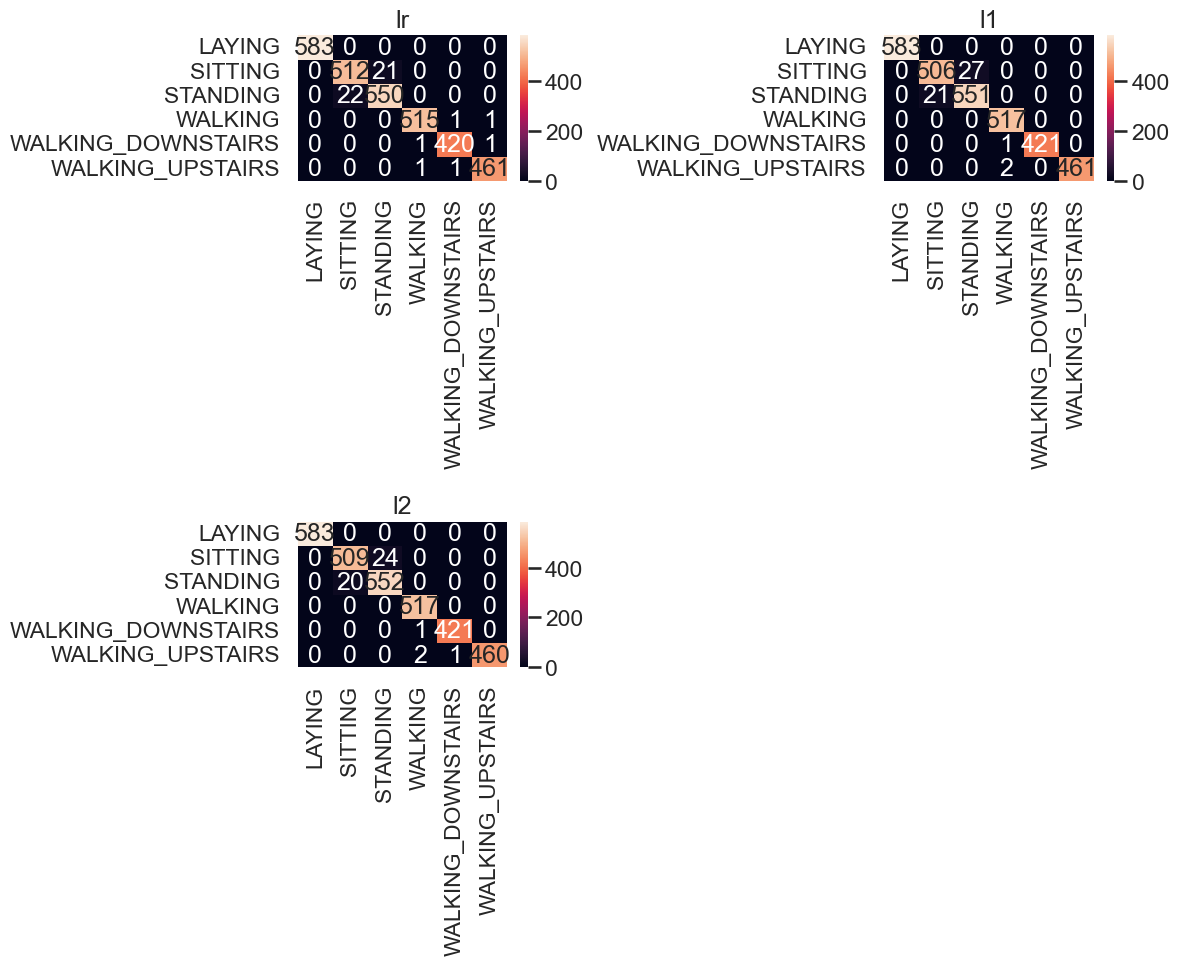

In [63]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_);
    ax.set(title=lab);
    
plt.tight_layout()